In [44]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999999999

requirejs.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [37]:
import torch
import pickle
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
from bertviz.model_view import show
import random
import torch
import torchtext
from tqdm import tqdm
import json

glove = torchtext.vocab.GloVe(name="6B",
                              dim=50)

sys.path.append('../../coco-caption')
from pycocotools.coco import COCO
#sys.path.append('/home/xilini/VL-BERT')

import matplotlib as mpl
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.5

import spacy
nlp = spacy.load('en_core_web_sm')

In [38]:
#import json
#with open('/scratch/nikolai/annotations/captions_val2014.json', 'r') as f:
#    data = json.load(f)
#    data['type'] = 'captions'
#with open('/scratch/nikolai/annotations/captions_val2014_new.json', 'w') as f:
#    json.dump(data, f)
#with open('/scratch/nikolai/annotations/instances_val2014.json', 'r') as f:
#    data = json.load(f)
#    data['type'] = 'captions'
#with open('/scratch/nikolai/annotations/instances_val2014_new.json', 'w') as f:
#    json.dump(data, f)

In [39]:
annotation_path = '/scratch/nikolai/annotations/captions_val2014_new.json'
annotation_path_inst = '/scratch/nikolai/annotations/instances_val2014_new.json'
image_folder = '/scratch/nikolai/'
coco = COCO(annotation_path)
coco_inst = COCO(annotation_path_inst)

image_info_basepath = '/scratch/nikolai/frcnn_val2014/'
att_basepath = '../../data/representations/test_encdec_attn/'
pred_file = '../../eval_results/fc_transformer_rl_bu_adaptive_test.json'
with open(pred_file, 'r') as f0:
    preds = json.load(f0)
#preds = torch.load(pred_file)

loading annotations into memory...
0:00:00.402468
creating index...
index created!
loading annotations into memory...
0:00:06.760162
creating index...
index created!


In [40]:
data_path = '../../bottom-up-attention/data/genome/1600-400-20/'

# Load classes
categories = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        categories.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [41]:
#json_id_to_class_id = {
#    v: i + 1 for i, v in enumerate(coco_inst.getCatIds())
#}
#class_id_to_json_id = {
#    v: k for k, v in json_id_to_class_id.items()
#}

class_id_to_text = {i: text for i, text in enumerate(categories)}
class_text_to_id = {text: i for i, text in enumerate(categories)}

colors = [None] * 1601

def show_image(image, boxes, class_names, label_offsets=None):
    class_names_to_ids = {n:v for n, v in enumerate(class_names)}
    w, h = image.size
    if label_offsets is None:
        label_offsets = [(0, 0)] * len(boxes)
    plt.imshow(image)
    for i, (bbox, class_id, label_offset) in enumerate(zip(reversed(boxes), reversed(class_names_to_ids), reversed(label_offsets))):
        i_ = len(boxes) - i - 1
        if colors[class_id] is None:
            color = (random.random(), random.random(), random.random())
            while color in colors:
                color = (random.random(), random.random(), random.random())
            colors[class_id] = color
        else:
            color = colors[class_id]
        rect = plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=color, linewidth=1)
        plt.gca().add_patch(rect)
        plt.gca().text(max(bbox[0] + label_offset[0], 10), max(bbox[1] + label_offset[1] - 2, 18),
                       '{} {}'.format(i_, class_names_to_ids[class_id]),
                       bbox=dict(facecolor=color, alpha=0.5), fontsize=5, color='white')
    plt.axis('off')
    plt.show()

def rescale(arr):
#     return (arr - arr.min())/(arr.max() - arr.min())
    return (arr - arr.min((1, 2, 3), keepdims=True))/(arr.max((1, 2, 3), keepdims=True) - arr.min((1, 2, 3), keepdims=True))

In [42]:
def extract_attention_weights(caption, att_weights):
    cap_length = len(caption.split())
    #TODO: investigate if the first token is the actual token caption or a start token
    # if it's the start token, then we need to take attention weights differently
    # is the first attention on the start token or on the actual token from the caption
    #print(att_weights[5, 0, 0, :])
    weights_true = att_weights.cpu()[:, :, :cap_length, :]
    return weights_true

0it [00:00, ?it/s]

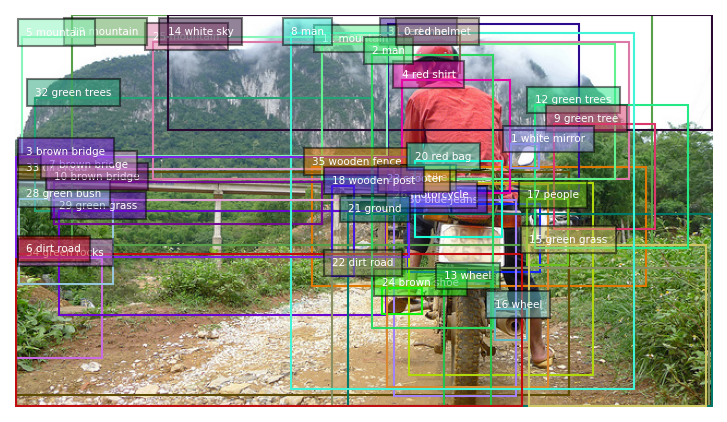

[(0, 'red helmet'), (1, 'white mirror'), (2, 'man'), (3, 'brown bridge'), (4, 'red shirt'), (5, 'mountain'), (6, 'dirt road'), (7, 'brown bridge'), (8, 'man'), (9, 'green tree'), (10, 'brown bridge'), (11, 'mountain'), (12, 'green trees'), (13, 'wheel'), (14, 'white sky'), (15, 'green grass'), (16, 'wheel'), (17, 'people'), (18, 'wooden post'), (19, 'mountain'), (20, 'red bag'), (21, 'ground'), (22, 'dirt road'), (23, 'scooter'), (24, 'brown shoe'), (25, 'mountain'), (26, 'motorcycle'), (27, 'bike'), (28, 'green bush'), (29, 'green grass'), (30, 'blue jeans'), (31, 'red man'), (32, 'green trees'), (33, 'dirt road'), (34, 'green rocks'), (35, 'wooden fence')]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0it [00:00, ?it/s]


In [48]:
all_average_not_linked = []
images_no_direct_match = []
attr_thresh = 0.1


for num, item in tqdm(enumerate(preds)):
        
    file_id = num + 1
    image_id = coco_id = item['image_id']
    caption = item['caption']
    filepath = item['file_path']

    # 6 x 5 x 8 x 21 x 36
    att_feat = torch.load(att_basepath + f'{file_id}.pt')
    beam5_att_feat = att_feat[:, 0, :, :, :]
    info = np.load(image_info_basepath + str(coco_id) + '.npz')
    bboxes = info['bbox']
    objects = info['objects']
    attr = info['attr']
    attr_conf = info['attr_conf']
    
    classes = []
    for i in range(36):
        cls = categories[objects[i]+1]
        if attr_conf[i] > attr_thresh:
            cls = attributes[attr[i]+1] + " " + cls
        classes.append(cls)

    cap_length = len(caption.split())
    attn_arr_text2img = extract_attention_weights(caption, beam5_att_feat)
    attn_arr_text2img = rescale(attn_arr_text2img.numpy())


    # for each head in each layer:
    # attention variability (to identify previous token heads)
    #heads = attn_arr_text2img.view(48, cap_length, 36)
    #heads = heads[:, :, 1:]
    
    image = Image.open(os.path.join(image_folder, filepath)).convert('RGB')

    attn_data = {
        'aa': {'attn': attn_arr_text2img.tolist(),
               'left_text': caption.split(),
               'right_text': [i for i in range(36)]}
    }

    # load classes from the extracted file
    # also, visualise notebook differently
    show_image(image, bboxes, classes)
    print([(num, cls) for num, cls in enumerate(classes)])
    show(caption, ' '.join(caption.split()), attn_data)
    
    break

In [ ]:
def choose_objects_attrs(image_info, cap, obj_thr = 0.5, attr = True, attr_thr = 0.5):
    
    target_words = []
    doc = nlp(cap)
    for noun_chunk in doc.noun_chunks:
        root_chunk = noun_chunk.root
        target_words.append(root_chunk.text)
    
    # TODO: implement control for such nouns, which are not among categories
    target_id = [class_text_to_id[c]-1 for c in target_words if c in class_text_to_id.keys()]
    #objects_missed = [elem for elem in target_words if elem not in class_text_to_id.keys()]
    
    idxs = []
    ids = []
    idxs_attr = []
    ids_attr = []
    image_info = image_info.tolist()
    object_ids = image_info['objects_id']
    objects_conf = image_info['objects_conf']
    match_found = set()
    
    if attr == True:
        attr_ids = image_info['attrs_id']
        attrs_conf = image_info['attrs_conf']
    
    for w1 in target_id:
        for idx, x in np.ndenumerate(object_ids):
            #if w1 == x and objects_conf[idx] >= obj_thr:
            # get only the target word indices
            #    match_found.add(class_id_to_text[w1+1])
            #    idxs.append(idx[0])
            #    ids.append(w1)
            #    if attr == True:
            #        if attrs_conf[idx] >= attr_thr:
            #            idxs_attr.append(idx[0])
            #            ids_attr.append(attr_ids[idx])
            if objects_conf[idx] >= obj_thr:
                # find for labels with somewhat similar meaning
                vis = glove[class_id_to_text[w1+1]]
                orig = glove[class_id_to_text[x+1]]
                cos_sim = torch.cosine_similarity(vis.unsqueeze(0), orig.unsqueeze(0))
                if cos_sim > 0.6:
                    idxs.append(idx[0])
                    ids.append(x)
                    match_found.add(class_id_to_text[w1+1])

    labels_detected = [class_id_to_text[e+1] for e in target_id]
    no_match = [i for i in labels_detected if i not in match_found]
    match_found = list(match_found)
    #print(match_found, no_match)
    return idxs, ids, len(match_found), len(no_match), idxs_attr, ids_attr

def extract_attention_weights(caption, att_weights):
    cap_length = len(caption.split())
    weights_true = att_weights.cpu()[:, :, :cap_length, :cap_length]
    return weights_true

In [ ]:
all_average_not_linked = []
images_no_direct_match = []

for num, item in tqdm(enumerate(preds)):
        
    file_id = num + 1
    image_id = coco_id = item['image_id']
    caption = item['caption']
    filepath = item['file_path']

    # 6 x 5 x 8 x 21 x 36
    att_feat = torch.load(att_basepath + f'{file_id}.pt')
    beam5_att_feat = att_feat[:, 0, :, :, :]
    info = np.load(image_info_basepath + str(coco_id) + '.npz')
    bboxes = info['bbox']

    cap_length = len(caption.split())
    attn_arr_text2img = extract_attention_weights(caption, beam5_att_feat)
    print(attn_arr_text2img.shape)
    attn_arr_text2img = rescale(attn_arr_text2img.numpy())


    # for each head in each layer:
    # attention variability (to identify previous token heads)
    #heads = attn_arr_text2img.view(48, cap_length, 36)
    #heads = heads[:, :, 1:]
    
    image = Image.open(os.path.join(image_folder, filepath)).convert('RGB')

    attn_data = {
        'aa': {'attn': attn_arr_text2img.tolist(),
               'left_text': caption.split(),
               'right_text': [i for i in range(36)]}
    }

    # load classes from the extracted file
    # also, visualise notebook differently
    classes = [json_id_to_class_id[c] for c in classes]
    show_image(image, bboxes, classes)
    show(caption, ' '.join(caption.split()), attn_data)
    
    break

In [ ]:
len(preds[0])

In [ ]:
# num images without any found match
len(images_no_direct_match)

In [ ]:
# percentage per image on average of non matched labels
sum(all_average_linked)/len(all_average_linked)
# outcome: the idea of linking with direct match and cosine sim is good,
# since on average per image there are only around 10% of heads from noun chunks which are not linked

In [ ]:
# TODO:
# 1. check why not all attention weights are stored (should be 4934, but we have less)
# 2. write up about the matching / cosine and why we need that
# (because we want to match words in the caption with the regions and see how attention heads look at these regions)
# (do they look at the regions which are mentioned by the caption or?)
# we also look at the heads of the noun chunks

In [ ]:
# IDEA: measure attention with GROUND-TRUTH CAPTIONS? not generated ones?? WHY?
# IDEA 2: we can also look at the transformer attention correctness, MOTIVATION?
# it would tell us if attention learned to look at the correct objects in general
# if it is looking at the correct ones, then we can start head role interpretation
# if not, we can't really connect words and objects in the image (we want the alignment between them to be super correct)

In [ ]:
# 6 x 8 x cap_length x num_objects (or already choose from object ids we want to show?)
# we want to make sure that the model pays attention to the correct / most probably objects
# how do we know it does not pay too much attention to the objects, which are unclear?
# measure distribution of the attention weights over the objects?


# messy results with attention
# possible problems:
# 1. visual features are extracted for objects which were identified, not taken from mscoco annotations
# 2. labels for these objects are not correct
# DO ASAP: check visualisations, are they correct? how does birtviz visualises the attention weights?
# - checked: seems to be in order
# DOUBLE CHECK: do we choose features correctly? not confused there, hopefully?
# - the features also look good
# 3. NEXT: train model with coco annotations somehow? although....VL-BERT used feature extractor
# 4. NEXT 2: how to find common patterns between different images (?)

In [ ]:
# collect all generated captions and look at their structure (?)

image_caption = {}
for num, item in enumerate(preds[0]):
    caption = item['caption']
    image_id = item['image_id']
    image_caption[image_id] = caption
all_captions = image_caption.values()

In [ ]:
# each caption seems to contain location information (on, next, etc)
# 1. find heads which look at the nouns ?
for c in all_captions:
    c = nlp(c)
    for noun_chunk in c.noun_chunks:
        root_chunk = noun_chunk.root
        print(root_chunk)
    break

In [ ]:
# what do we want to look at?
# heads that are focused on generating the root part of the caption?
# which heads look at the root of the sentence, and which of them look at the relations of this root with
# the other parts of the sentence?
# spacy dependency relations(?)